<div style="border:solid Chocolate 2px; padding: 40px">

# Определение стоимости автомобилей

</div>

Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. 

Задача: построить модель для определения стоимости автомобиля. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.
 
Примечания:

- Для оценки качества моделей применяем метрику RMSE.
- Значение метрики RMSE должно быть меньше 2500.

## Подготовка данных

In [1]:
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.compose import ColumnTransformer

import os

In [2]:
pth = '/datasets/autos.csv'
pth2 = 'autos.csv'

if os.path.exists(pth):
    data = pd.read_csv(pth)
elif os.path.exists(pth2):
    data = pd.read_csv(pth2)
else:
    print('Something is wrong')

data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Признаки
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
-  NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

Целевой признак
- Price — цена (евро)

### Предобработка данных

Сначала проверим, есть ли в датасете полные дубликаты.

In [4]:
print("Наличие явных дубликатов в датасете:", data.duplicated().sum())

Наличие явных дубликатов в датасете: 4


In [5]:
data = data.drop_duplicates()
print("Наличие явных дубликатов в датасете:", data.duplicated().sum())

Наличие явных дубликатов в датасете: 0


В датасете есть неинформативные признаки, которые не пригодятся нам для анализа, можем сразу удалить их. Это DateCrawled, RegistrationMonth, DateCreated, NumberOfPictures, PostalCode и LastSeen. 

In [6]:
data = data.drop(['DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1)
data.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


Проверим пропуски в данных.

In [7]:
pd.DataFrame(round(data.isna().mean()*100,)).style.background_gradient('coolwarm')

,0
Price,0.000000
VehicleType,11.000000
RegistrationYear,0.000000
Gearbox,6.000000
Power,0.000000
Model,6.000000
Kilometer,0.000000
FuelType,9.000000
Brand,0.000000
Repaired,20.000000


Все пропуски - в категориальных признаках, причем их довольно значительное количество, т.е. их удаление может значительно сказаться на работе модели. Можем заменить все пропуски на "unknown".

In [8]:
data = data.fillna("unknown")
data.isna().sum()

Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
Repaired            0
dtype: int64

Изучим аномальные значения.

In [9]:
data.describe()

,Price,RegistrationYear,Power,Kilometer
count,354365.000000,354365.000000,354365.000000,354365.000000
mean,4416.679830,2004.234481,110.093816,128211.363989
std,4514.176349,90.228466,189.851330,37905.083858
min,0.000000,1000.000000,0.000000,5000.000000
25%,1050.000000,1999.000000,69.000000,125000.000000
50%,2700.000000,2003.000000,105.000000,150000.000000
75%,6400.000000,2008.000000,143.000000,150000.000000
max,20000.000000,9999.000000,20000.000000,150000.000000


Мы видим много аномальных значений, например, цена или мощность = 0, год 1000 и 9999. 

Начнем с Power. Быстрым поиском в открытых источниках выясняем, что максимально возможная мощность автомобилей - до 5 000 (и это для мощных грузовиков, которые вряд ли будут в большом количестве присутствовать в нашем сервисе по продаже авто). 

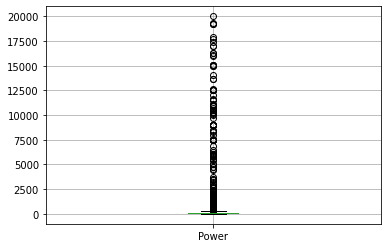

In [10]:
data.boxplot(column='Power');

Очень большой хвост выбросов сверху. Во все данные, что выше - вероятно, по ошибке добавили два лишних нуля. Посмотрим на эти данные.

In [11]:
data.loc[data['Power']>=5000].head(20)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
7661,1499,small,1999,manual,7515,lupo,150000,petrol,volkswagen,unknown
11039,0,sedan,1998,manual,10317,other,150000,petrol,fiat,no
25232,10900,bus,2009,manual,10520,caddy,150000,gasoline,volkswagen,no
33952,3740,small,2006,manual,6920,aygo,90000,unknown,toyota,no
44520,2500,convertible,1998,manual,7512,golf,150000,unknown,volkswagen,unknown
45053,15800,convertible,2014,auto,10218,fortwo,30000,petrol,smart,unknown
45216,1690,sedan,1999,manual,7544,golf,125000,petrol,volkswagen,unknown
53158,1200,small,2001,manual,5411,seicento,150000,unknown,fiat,no
56971,1995,wagon,2002,manual,11530,focus,150000,petrol,ford,no
57622,1,unknown,5000,unknown,5000,clk,5000,petrol,mercedes_benz,unknown


Всё-таки непохоже, что просто добавили лишние нули, поэтому мы не можем просто исправить эти данные, поделив на 100. 
То же самое можно сказать об аномальной цене и километраже. Что касается RegistrationYear, мы могли бы предположить, что под 9999 имелся в виду 1999 г., а 1000 = 2000 г. Но подтверждения этому у нас нет, к тому же есть и другие аномальные годы, которые не понятно как можно было бы расшифровать (например, 5000). 

Принимаем решение удалить все выбросы. К тому же, метрика RMSE (и MSE) чувствительна к выбросам, поэтому их удаление позволит нам более качественно обучить модели.

In [12]:
#функция для вычленения аномальных данных методом межквантильного расстояния
def iqr(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - (1.5 * IQR)
    upper = Q3 + (1.5 * IQR)
    
    return lower, upper

In [13]:
for i in ['RegistrationYear', 'Power', 'Kilometer', 'Price']:
    lower, upper = iqr(data[i])
    data = data[(data[i]>=lower)&(data[i]<=upper)]

In [14]:
data.describe()

,Price,RegistrationYear,Power,Kilometer
count,272404.000000,272404.000000,272404.000000,272404.000000
mean,2933.546578,2002.503502,99.812628,143024.092891
std,2621.475383,6.094292,54.696089,15753.581318
min,0.000000,1986.000000,0.000000,90000.000000
25%,950.000000,1999.000000,65.000000,150000.000000
50%,2000.000000,2002.000000,101.000000,150000.000000
75%,4200.000000,2006.000000,138.000000,150000.000000
max,10999.000000,2019.000000,254.000000,150000.000000


Минимальная цена - 0 евро, выглядит неправдоподобно. Посмотрим, какова доля объявлений с ценой ниже 50 евро.

In [15]:
data.Price[data.Price < 50].count()/data.Price.count()

0.03517569492371624

Меньше 4%. Можем удалить эти данные без вреда для датасета.

In [16]:
data = data[data.Price >=50]

Минимальное значение Power = 0, что тоже выглядит аномально, уберем эти данные.

In [17]:
data = data[data.Power > 0]

### Выводы

Датасет довольно объемный, что хорошо, поскольку у моделей будет больше данных для обучения. Однако, он потребовал некоторой предобработки:

- удаление дубликатов;
- заполнение пропусков в категориальных признаках - их было довольно много, поэтому заполняли заглушкой unknown;
- удаление выбросов и аномалий в количественных признаках.

Теперь датасет готов для дальнейшего обучения моделей.

## Обучение моделей

### Подготовка выборок

В нашем распоряжении достаточно объемный датасет, поэтому мы можем позволить себе разбить его на три выборки: трейновую, валидационную и тестовую. Кросс-валидацию в данном кейсе считаем избыточной, поскольку она на таком объемном датасете будет тратить много времени, особенно на моделях градиентного бустинга.

In [18]:
train, valid, test = np.split(data.sample(frac=1, random_state=321), [int(.6*len(data)), int(.8*len(data))])
print(train.shape)
print(valid.shape)
print(test.shape)

(140178, 10)
(46726, 10)
(46726, 10)


In [19]:
features_train = train.drop(['Price'], axis=1)
target_train = train['Price']

features_valid = valid.drop(['Price'], axis=1)
target_valid = valid['Price']

features_test = test.drop(['Price'], axis=1)
target_test = test['Price']

del data

Выделим в отдельные списки категориальные и количественные признаки.

In [20]:
cat_features = ['VehicleType', 'RegistrationYear', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']
num_features = ['Power', 'Kilometer']

### CatBoost

In [21]:
results = {}

In [22]:
#подбор гиперпараметров для CatBoost

params = {'iterations': [50,100,200], 
          'depth': [1, 2, 3],
          'learning_rate':[0.2, 0.3, 0.4] }

catboost_cv = RandomizedSearchCV(estimator=CatBoostRegressor(cat_features=cat_features, verbose = 300),
                                 param_distributions=params, 
                                 scoring='neg_mean_squared_error', 
                                 cv=3, n_iter=15, random_state=321)

catboost_cv.fit(features_train, target_train)

catboost_model = catboost_cv.best_estimator_

0:	learn: 2455.5641122	total: 76.7ms	remaining: 3.76s
49:	learn: 1436.2406645	total: 700ms	remaining: 0us
0:	learn: 2454.4024404	total: 24ms	remaining: 1.17s
49:	learn: 1433.1850590	total: 667ms	remaining: 0us
0:	learn: 2456.1827155	total: 24.8ms	remaining: 1.21s
49:	learn: 1435.2133550	total: 676ms	remaining: 0us
0:	learn: 2134.7015465	total: 32.1ms	remaining: 3.18s
99:	learn: 1183.1164562	total: 2.11s	remaining: 0us
0:	learn: 2126.8074274	total: 38.7ms	remaining: 3.83s
99:	learn: 1181.0004174	total: 2.2s	remaining: 0us
0:	learn: 2129.0501386	total: 33.2ms	remaining: 3.29s
99:	learn: 1181.1329726	total: 2.21s	remaining: 0us
0:	learn: 2392.1807556	total: 40.5ms	remaining: 8.05s
199:	learn: 1211.1413067	total: 4.91s	remaining: 0us
0:	learn: 2389.7855239	total: 38.4ms	remaining: 7.64s
199:	learn: 1207.5128809	total: 4.59s	remaining: 0us
0:	learn: 2391.5145332	total: 38.4ms	remaining: 7.65s
199:	learn: 1206.1437433	total: 4.85s	remaining: 0us
0:	learn: 2392.1807556	total: 28.4ms	remaining

In [23]:
%%time
# посмотрим на скорость обучения модели
catboost_model.fit(features_train, target_train)

0:	learn: 2241.7809411	total: 89.7ms	remaining: 17.8s
199:	learn: 1147.8986000	total: 11.9s	remaining: 0us
CPU times: user 12 s, sys: 152 ms, total: 12.2 s
Wall time: 12.9 s


In [24]:
%%time
# посмотрим на результаты модели на валидационной выборке
preds = catboost_model.predict(features_valid)

rmse = mean_squared_error(target_valid, preds, squared=False)
results['CatBoost'] = rmse
print(rmse)

1140.0410521998474
CPU times: user 111 ms, sys: 4.1 ms, total: 115 ms
Wall time: 112 ms


### LightGBM

In [25]:
for i in cat_features:
    features_train[i] = features_train[i].astype('category')
    features_valid[i] = features_valid[i].astype('category')
    features_test[i] = features_test[i].astype('category')

In [26]:
%%time

lgbm_model = LGBMRegressor(max_depth=3, learning_rate=0.4, verbose=100)

lgbm_model.fit(features_train, target_train)

[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.779656
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.271096
[LightGBM] [Debug] init for col-wise cost 0.003427 seconds, init for row-wise cost 0.095392 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004598 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Sparse Multi-Val Bin
[LightGBM] [Info] Total Bins 576
[LightGBM] [Info] Number of data points in the train set: 140178, number of used features: 9
[LightGBM] [Info] Start training from score 3183.751273
[LightGBM] [Debug] Trained a tree with leaves = 8 and depth = 3
[LightGBM] [Debug] Trained a tree with leaves = 8 and depth = 3
[LightGBM] [Debug] Trained a tree with leaves = 8 and depth = 3
[LightGBM] [Debug] Trained a tree with leaves = 8 and depth = 3
[LightGBM] [Debug] Trained a t

LGBMRegressor(learning_rate=0.4, max_depth=3, verbose=100)

In [27]:
%%time
# посмотрим на результаты модели на валидационной выборке
preds = lgbm_model.predict(features_valid)

rmse = mean_squared_error(target_valid, preds, squared=False)
results['LightGBM'] = rmse
print(rmse)

1109.361694579379
CPU times: user 258 ms, sys: 4.17 ms, total: 262 ms
Wall time: 205 ms


### Решающее дерево

In [28]:
# Pipeline для Решающего дерева

# кодируем категориальные признаки
cat_transformer = Pipeline(steps=[
    ('ordinal_encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
])

# масштабируем числовые признаки
num_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()),
])

# объединяем Pipeline для предобработки
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', cat_transformer, cat_features),
        ('num', num_transformer, num_features),
    ])

# Определение финального Pipeline
tree_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                            ('model', DecisionTreeRegressor(random_state=321))])


In [29]:
# Подбор гиперпараметров
tree_params = {
   'model__max_depth': range(1,8,1),
   'model__min_samples_leaf': range(2,8,1),
   'model__min_samples_split': [2,3,4,5]
}

tree_cv = RandomizedSearchCV(tree_pipe, tree_params, cv=3, random_state=321, 
                            scoring='neg_mean_squared_error', n_jobs=-1)

tree_cv.fit(features_train, target_train)
tree_model = tree_cv.best_estimator_

In [30]:
%%time
# смотрим на скорость обучения модели

tree_model.fit(features_train, target_train)

CPU times: user 342 ms, sys: 0 ns, total: 342 ms
Wall time: 348 ms


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('ordinal_encoder',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['VehicleType',
                                                   'RegistrationYear',
                                                   'Gearbox', 'Model',
                                                   'FuelType', 'Brand',
                                                   'Repaired']),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                   

In [31]:
%%time
# посмотрим на результаты модели на валидационной выборке
preds = tree_model.predict(features_valid)

rmse = mean_squared_error(target_valid, preds, squared=False)
results['DecisionTree'] = rmse
print(rmse)

1425.1090778414946
CPU times: user 60.5 ms, sys: 3.94 ms, total: 64.4 ms
Wall time: 63 ms


### Случайный лес

In [32]:
# Pipeline для Случайного леса

forest_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                            ('model', RandomForestRegressor(random_state=321))])

In [33]:
# Подбор гиперпараметров

forest_params = {
   'model__max_depth': range(1,8,1),
   'model__max_features': [None, "sqrt", "log2"],
   'model__n_estimators': [10, 15, 20],
   'model__min_samples_leaf': range(2,8,1),
   'model__min_samples_split': [2,3,4,5]
}

forest_cv = RandomizedSearchCV(forest_pipe, forest_params, cv=3, random_state=321, 
                            scoring='neg_mean_squared_error', n_jobs=-1)

forest_cv.fit(features_train, target_train)

forest_model = forest_cv.best_estimator_

In [34]:
%%time

forest_model.fit(features_train, target_train)

CPU times: user 636 ms, sys: 0 ns, total: 636 ms
Wall time: 642 ms


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('ordinal_encoder',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['VehicleType',
                                                   'RegistrationYear',
                                                   'Gearbox', 'Model',
                                                   'FuelType', 'Brand',
                                                   'Repaired']),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                   

In [35]:
%%time
# посмотрим на результаты модели на валидационной выборке
preds = forest_model.predict(features_valid)

rmse = mean_squared_error(target_valid, preds, squared=False)
results['RandomForest'] = rmse
print(rmse)

1379.6765117242649
CPU times: user 89.4 ms, sys: 18 µs, total: 89.4 ms
Wall time: 95.5 ms


### Линейная регрессия

In [36]:
%%time
# Pipeline для Линейной регрессии
cat_transformer = Pipeline(steps=[
    ('ohe', OneHotEncoder(handle_unknown='ignore')),
])

num_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()),
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', cat_transformer, cat_features),
        ('num', num_transformer, num_features),
    ])

# Определение финального Pipeline
linear_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                            ('model', LinearRegression())])

linear_pipe.fit(features_train, target_train)

CPU times: user 7.71 s, sys: 11.6 s, total: 19.3 s
Wall time: 19.2 s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['VehicleType',
                                                   'RegistrationYear',
                                                   'Gearbox', 'Model',
                                                   'FuelType', 'Brand',
                                                   'Repaired']),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Power', 'Kilometer'])])),
                ('model', LinearRegression())])

In [37]:
%%time
preds = linear_pipe.predict(features_valid)

rmse = mean_squared_error(target_valid, preds, squared=False)
results['LinearRegression'] = rmse
print(rmse)

1287.7209380993374
CPU times: user 73.8 ms, sys: 74 µs, total: 73.9 ms
Wall time: 72.1 ms


## Анализ моделей

In [38]:
results = pd.Series(results)
results

CatBoost            1140.041052
LightGBM            1109.361695
DecisionTree        1425.109078
RandomForest        1379.676512
LinearRegression    1287.720938
dtype: float64

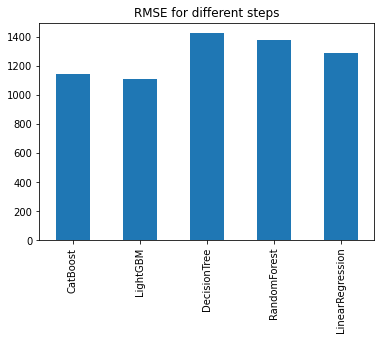

In [39]:
results.plot(kind='bar', title='RMSE for different steps')
plt.show()

Все модели показали RMSE меньше 2500. Наилучшие результаты - у моделей градиентного бустинга. При этом LightGBM обучается быстрее, чем CatBoost. Скорость предсказания у обеих моделей высокая, у CatBoost несколько ниже.

Что касается остальных моделей, среди них лучшие результаты RMSE показала Линейная регрессия. Но она и самая долгая среди этих моделей. Быстрее всех обучается модель Решающего дерева. По предсказаниям аналогичная ситуация: самая быстрая модель - решающее дерево.

Таким образом, если скорость - решающий фактор, можно использовать модель Решающего дерева, хотя его точность предсказания самая низкая, но отвечает запросу "RMSE меньше 2500".

Если рассматриваем баланс между скоростью и точностью, оптимальный вариант - модель LightBGM.

### Тестирование модели

In [40]:
%%time
preds = lgbm_model.predict(features_test)

rmse = mean_squared_error(target_test, preds, squared=False)
rmse

CPU times: user 289 ms, sys: 0 ns, total: 289 ms
Wall time: 285 ms


1110.5349626751113

Модель показала хороший результат.

## Выводы

Перед нами стояла задача: построить модель для определения стоимости автомобиля. 

Критерии, на которые мы опирались: 

- качество предсказания (метрика RMSE не менее 2500);
- скорость предсказания;
- время обучения.

Мы предобработали данные и проверили несколько моделей: CatBoost, LightGBM, Решающее дерево, Случайный лес и Линейная регрессия, применив различные гиперпараметры.

В результате нам удалось выбрать наиболее эффективную модель, применение которой даёт хороший показатель RMSE на тестовой выборке: 1110.5 и демонстрирует высокую скорость обучения и предсказания.